In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import glob
import shutil

from tslearn.utils import to_time_series_dataset
from tslearn.metrics import cdist_dtw
from sklearn_extra.cluster import KMedoids

In [2]:
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
df = pd.DataFrame()
for i in range(111):
    cajero = pd.read_csv(f'data_processed/df_resultado_cajero_{i}.csv')
    target = cajero['TARGET']
    df[f'{i}'] = target


df = df.T

In [5]:
# --- Paso 1: Normalización (z-score por serie) ---
df_normalized = df.sub(df.mean(axis=1), axis=0).div(df.std(axis=1), axis=0)

# --- Paso 2: Convertir a formato tslearn (n_series, T, 1) ---
X = to_time_series_dataset(df_normalized.values.astype(float))

# --- Paso 3: Calcular matriz de distancias DTW ---
D = cdist_dtw(X)  # devuelve matriz (n, n) con distancias DTW

# --- Paso 4: Clustering K-Medoids con matriz precomputada ---
k = 4
kmedoids = KMedoids(
    n_clusters=k,
    metric="precomputed",
    init="k-medoids++",  # si tu versión no soporta esto, usá "random"
    random_state=42
)
labels = kmedoids.fit_predict(D)

# --- Paso 5: Agregar etiquetas al DataFrame original ---
df_clusters = df_normalized.copy()
df_clusters["Cluster"] = labels

# --- Opcional: Ver distribución de clusters ---
print(df_clusters["Cluster"].value_counts().sort_index())

Cluster
0    30
1    22
2    38
3    21
Name: count, dtype: int64


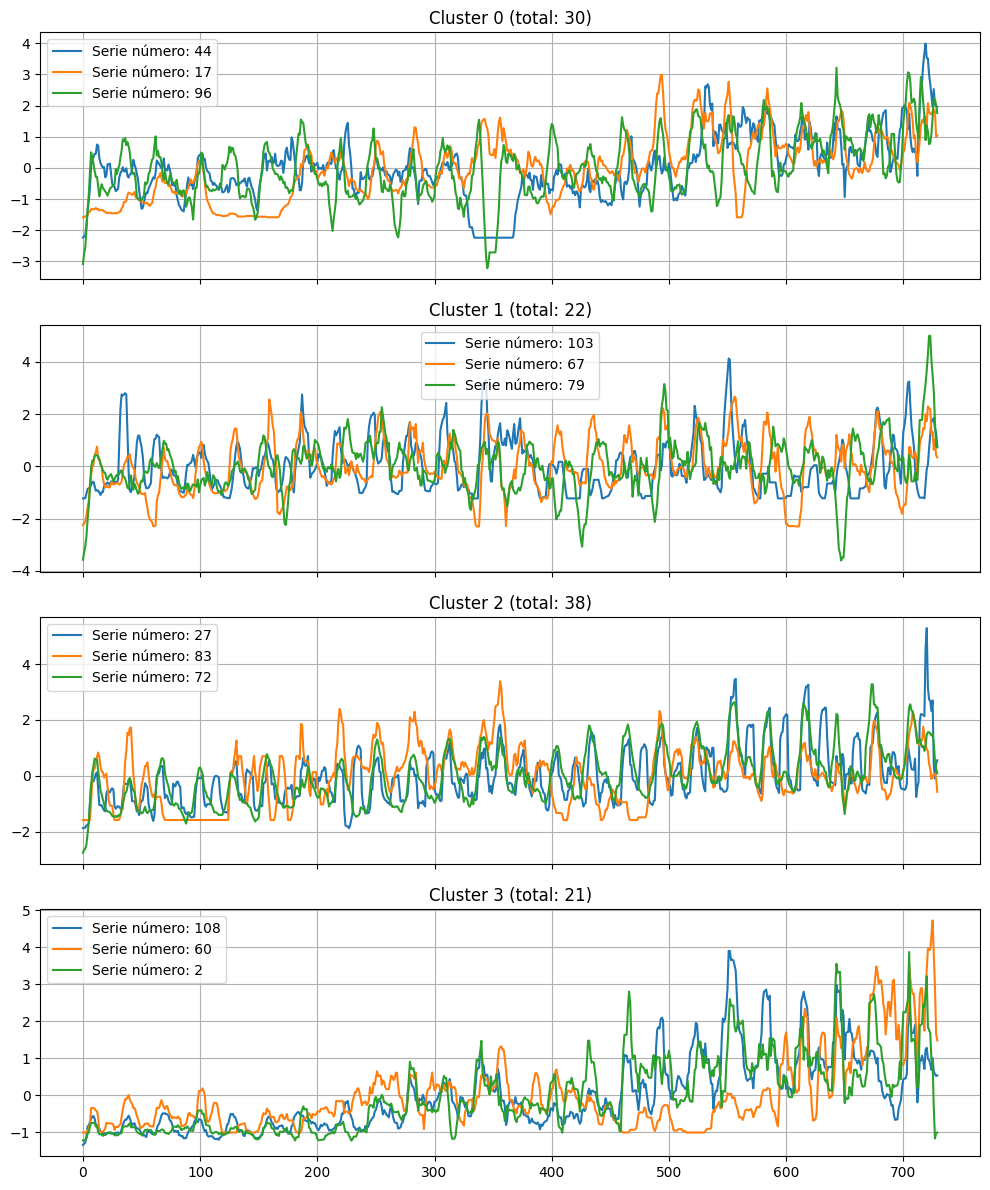

In [11]:
k = df_clusters["Cluster"].nunique()  # cantidad de clusters detectados

fig, axes = plt.subplots(k, 1, figsize=(10, 3 * k), sharex=True)

if k == 1:
    axes = [axes]

for cluster_id in range(k):
    ax = axes[cluster_id]
    # Filtrar las series que pertenecen al cluster actual
    subset = df_clusters[df_clusters["Cluster"] == cluster_id].drop(columns="Cluster")
    
    # Tomar hasta 3 series al azar para mostrar
    muestras = subset.sample(n=min(3, len(subset)), random_state=3)
    
    for idx, (_, serie) in enumerate(muestras.iterrows()):
        ax.plot(serie.values, label=f'Serie número: {serie.name}')
    
    ax.set_title(f'Cluster {cluster_id} (total: {len(subset)})')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [20]:
data_dir = "data_processed"

#Asegurarnos que df_clusters tiene la columna "Cluster"
assert "Cluster" in df_clusters.columns, "df_clusters debe tener la columna 'Cluster'."

# Obtener los clusters únicos presentes
clusters_unicos = sorted(df_clusters["Cluster"].unique())

# Crear carpetas cluster_<c> para cada cluster presente
for c in clusters_unicos:
    os.makedirs(os.path.join(data_dir, f"cluster_{c}"), exist_ok=True)

# Procesar cajeros agrupados por cluster
for c in clusters_unicos:
    # Cajeros (índices) que pertenecen a este cluster
    cajeros_en_cluster = df_clusters.index[df_clusters["Cluster"] == c]
    
    for cajero_id in cajeros_en_cluster:
        src = os.path.join(data_dir, f"df_resultado_cajero_{cajero_id}.csv")
        if not os.path.exists(src):
            print(f"[WARN] No existe archivo para cajero {cajero_id}: {src}")
            continue
        
        # Leer, agregar columna Cluster, guardar en carpeta cluster_c
        df_cajero = pd.read_csv(src)
        df_cajero["Cluster"] = c
        
        dst = os.path.join(data_dir, f"cluster_{c}", f"df_resultado_cajero_{cajero_id}.csv")
        df_cajero.to_csv(dst, index=False)

In [25]:
#Delete original files
for file in glob.glob(os.path.join(data_dir, "df_resultado_cajero_*.csv")):
    os.remove(file)
    
